# Free Diving in Food Facts

The [dataset](https://world.openfoodfacts.org/data) presents many [fields](https://static.openfoodfacts.org/data/data-fields.txt) for each product. 

In [62]:
import re
import pickle
import importlib # reload an imported module 
import time
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import json
import folium
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from importlib import reload 
from IPython.display import clear_output

In [57]:
import lucas_utils as lu
# Once the script is imported, calling import will not reload the script if it is modified 
lu = importlib.reload(lu)

In [3]:
# define some constants
DATASET_PATH = 'data/en.openfoodfacts.org.products.csv'
ENCODING = 'UTF-8'
PICKLE_DATASET_PATH = 'data/en.openfoodfacts.org.products.pickle'

In [4]:
# Pickle utilities
def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

def save_pickle(result, file_path = 'pickle'):
    with open(file_path, 'wb') as file:
        pickle.dump(result, file)

**Load the data:**

---
---
Load the whole dataset from the `.csv` file (takes a minute):

In [ ]:
food_facts_df = pd.read_csv(DATASET_PATH, encoding=ENCODING, sep='\t',low_memory=False)

In [ ]:
# Save the dataframe with pickle for faster loading
save_pickle(food_facts_df, PICKLE_DATASET_PATH)

---
Or use pickle instead to load the dataframe directly:

In [5]:
food_facts_df = load_pickle(PICKLE_DATASET_PATH)

---
---

In [6]:
print('The dataset contains ',len(food_facts_df),' entries.')

The dataset contains  1030905  entries.


**Use a sample of the dataset**

Use only a sample containing 10'000 products for experimenting:

In [7]:
sample_df = food_facts_df.head(10000).copy()

In [8]:
sample_df.head(2)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Question: What are the levels of interdependencies between nations based on their production and importations?

Let us first identify the [fields](https://static.openfoodfacts.org/data/data-fields.txt) that are relevant to the question:

In [9]:
FIELDS = ['origins',
          'origins_tags',
          'manufacturing_places',
          'manufacturing_places_tags',
          'first_packaging_code_geo',
          'cities',
          'cities_tags',
          'purchase_places',
          'stores',
          'countries',
          'countries_tags']
# 'countries_fr' generates a key error

Let us observe the type of information each of them offers: 

In [10]:
for field in FIELDS:
    print('Field: ' + field)
    print('\t',lu.get_field_without_nan(sample_df,field).head(4).values)

Field: origins
	 ['France' 'Québec' 'Québec' 'France']
Field: origins_tags
	 ['france' 'quebec' 'quebec' 'france']
Field: manufacturing_places
	 ['France' 'France' 'Brossard Québec' 'Brossard Québec']
Field: manufacturing_places_tags
	 ['france' 'france' 'brossard-quebec' 'brossard-quebec']
Field: first_packaging_code_geo
	 ['47.833333,-0.333333' '47.883333,-2.766667' '49.083333,2.75'
 '47.7,-0.366667']
Field: cities
	 []
Field: cities_tags
	 ['sable-sur-sarthe-sarthe-france' 'bignan-morbihan-france'
 'lagny-le-sec-oise-france' 'daumeray-maine-et-loire-france']
Field: purchase_places
	 ['France' 'Roissy,France' 'Roissy,France' 'France']
Field: stores
	 ['courte paille' 'Marks & Spencer' 'Marks & Spencer' "Sainsbury's"]
Field: countries
	 ['France' 'France' 'France' 'en:France']
Field: countries_tags
	 ['en:france' 'en:france' 'en:france' 'en:france']


An important criterion to select reliable fields is how complete the information is per field:

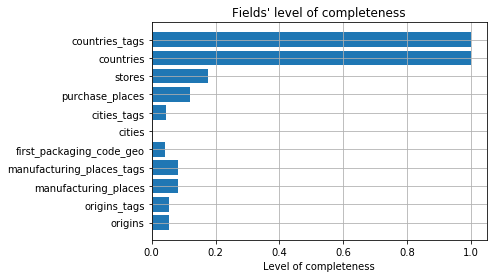

In [37]:
# Levels for the full dataset
lu.show_fields_completeness(food_facts_df,FIELDS,verbose=True)

Clearly, the most reliable fields are `countries` and `countries_tags` since they are almost missing no data! Furthermore, `countries_tags` is essentially a cleaned up version of `countries`. We will therefore definitely use this field. It indicates where the product is sold.

Let us analyze this field more in depth. Let us see what `unique()` returns for this field:

In [13]:
# Store unique 'countries_tag' 
unique_countries_tag_s = pd.Series(sample_df['countries_tags'].dropna().unique())

In [14]:
unique_countries_tag_s.head(6)

0                     en:france
1              en:united-states
2                    en:ireland
3                    en:belgium
4             en:united-kingdom
5    en:france,en:united-states
dtype: object

The data seems to be clean! Some products exist in different countries. When this is the case, the `countries_tag` field contains a list of countries separated by commas. To really identify unique countries the dataframe should be modified to list a single country per product. In this way, we will exactly know what countries are present and how many products are found in each of them.

To do so, we need to explode the `countries_tags` to contain a single value instead of a list of countries. This will create a new row which is a duplicate of the original one where the `countries_tags` field contains a single value. 

In [15]:
unique_countries_s = lu.get_unique_values_of_field(food_facts_df,field='countries_tags')

In [16]:
# Store the countries in a text file
with open('data/countries.txt','wb') as file: 
    for i,country in enumerate(unique_countries_s):
        file.write((country+'\n').encode('utf8'))

We also need to know how many products are listed per country, let's have a look:

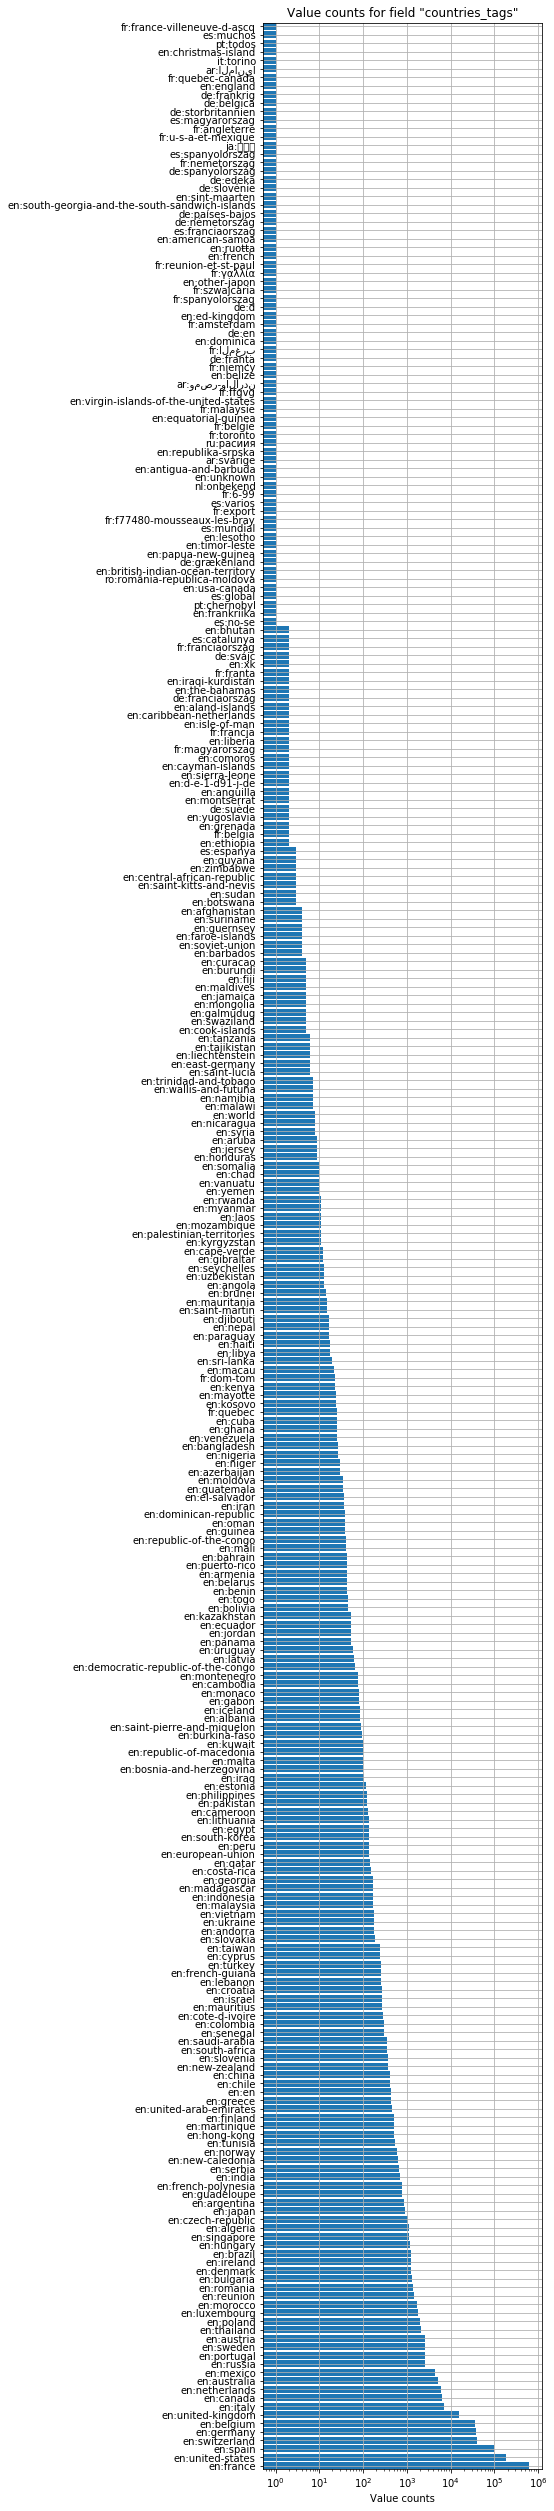

In [58]:
countries_counts = lu.show_field_value_counts(food_facts_df, size=(5,45))

The previous plot is fine but not really, let us plot the data onto a map to really see where the information is mainly located. 

In [174]:
# Load the GeoJson file 
geo_json_data = json.load(open(world_coutries_geo_path))

In [175]:
# Convert json countries names to lower case
for i in range(0,len(geo_json_data['features'])):
    geo_json_data['features'][i]['properties']['name'] = geo_json_data['features'][i]['properties']['name'].lower()

In [176]:
# Create a dataframe of the countries count with cleaned up names to match with the json names
countries_counts_df = pd.DataFrame(lu.get_field_value_counts(food_facts_df))\
                        .reset_index().rename(columns={'index':'name','countries_tags':'counts'})

# Remove counts less than 10
countries_counts_df = countries_counts_df[countries_counts_df['counts'] > 10]

# Keep selected prefixes
prefixes = ('en:') # en: english
for pre in prefixes:
    countries_counts_df = countries_counts_df[countries_counts_df['name'].apply(lambda x : pre in str(x))]

# Remove prefixes from name
countries_counts_df['name'] = countries_counts_df['name'].apply(lambda x : re.sub(r'.*:', '', str(x)))\
                                                        .apply(lambda x : re.sub(r'-', ' ', str(x)))
    
countries_counts_df.head()

,name,counts
0,france,618494
1,united states,181818
2,spain,95196
3,switzerland,38918
4,germany,37379


In [177]:
# get a list of the countries from the json file
json_countries = []
for i in range(0,len(geo_json_data['features'])):
    json_countries.append(geo_json_data['features'][i]['properties']['name'])

In [178]:
# Create a dictionary to match the most important missing names
df_to_json_names = {}
df_to_json_names['united states'] = 'united states of america'
df_to_json_names['england'] = 'united kingdom'
df_to_json_names['east germany'] = 'germany'
countries_counts_df['name'] = countries_counts_df['name'].replace(df_to_json_names)

No match for reunion -> dropping
No match for singapore -> dropping
No match for guadeloupe -> dropping
No match for french polynesia -> dropping
No match for serbia -> dropping
No match for hong kong -> dropping
No match for martinique -> dropping
No match for en -> dropping
No match for cote d ivoire -> dropping
No match for mauritius -> dropping
No match for french guiana -> dropping
No match for andorra -> dropping
No match for european union -> dropping
No match for malta -> dropping
No match for republic of macedonia -> dropping
No match for saint pierre and miquelon -> dropping
No match for monaco -> dropping
No match for bahrain -> dropping
No match for mayotte -> dropping
No match for macau -> dropping
No match for saint martin -> dropping
No match for seychelles -> dropping
No match for gibraltar -> dropping
No match for cape verde -> dropping
No match for palestinian territories -> dropping


In [ ]:
# See what countries from the dataset have no match with the json names and drop them
for country_tag in countries_counts_df['name']:
    if not country_tag in json_countries:
        print('No match for',country_tag,'-> dropping')
        # Drop the missing elements
        i = countries_counts_df[countries_counts_df.name == country_tag].index
        countries_counts_df = countries_counts_df.drop(i)

In [187]:
# Remove countries from the json that are not in the dataframe
for i in range(0,len(geo_json_data['features'])):
    if i == len(geo_json_data['features']):
        break
    if not geo_json_data['features'][i]['properties']['name'] in countries_counts_df['name'].values:
        print('Dropping',geo_json_data['features'][i]['properties']['name'])
        geo_json_data['features'].pop(i)

In [186]:
# Folium plot!!!
world_coutries_geo_path = r'data/world-countries.json'
map_world = folium.Map([30,0], tiles='cartodbpositron', zoom_start=2)
#folium.GeoJson(geo_json_data).add_to(map_world)
folium.Choropleth(
    geo_data=geo_json_data,
    name='choropleth',
    data=countries_counts_df,
    columns=['name', 'counts'],
    key_on='features.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of products'
).add_to(map_world)
map_world

AttributeError: 'NoneType' object has no attribute 'get'